In [10]:
import os

# Set up the path to the data.
data_path = '/vol/bitbucket/az620/radiotherapy/data'

if os.path.exists(data_path):
    print("The path exists.")
    print('The relevant contents are...')
    for x in sorted(os.listdir(data_path)): 
        if 'nnUNet' in x: print(f'   {x}')
else:
    print("The path does not exist.")

The path exists.
The relevant contents are...
   nnUNet_predictions_bglocker
   nnUNet_preprocessed
   nnUNet_raw
   nnUNet_results


In [11]:
id_anorectum = 'Dataset001_Anorectum'

In [12]:
import json

file_path = os.path.join(data_path, 'nnUNet_raw', id_anorectum, 'dataset.json')

with open(file_path, 'r') as file:
    data = json.load(file)

data

{'channel_names': {'0': 'CT'},
 'labels': {'background': 0, 'anorectum': 1},
 'numTraining': 100,
 'file_ending': '.nii.gz',
 'overwrite_image_reader_writer': 'SimpleITKIO'}

## Run Total Segmentator for the anorectum case

In [13]:
import nibabel as nib
from totalsegmentator.python_api import totalsegmentator

In [14]:
from totalsegmentator.config import setup_nnunet, setup_totalseg
from totalsegmentator.libs import download_pretrained_weights

import os


def fetch_pretrained_totalsegmentator_model():
    """
    Fetch the pretrained TotalSegmentator model.

    The total segmentator model loads a separately trained nnUNet model for each new class
    However, it is not trained on the parametrium case. Therefore, we load the general 
    model and attempt to finetune it on my case.
    """

    os.environ['TOTALSEG_HOME_DIR'] = '/vol/bitbucket/az620/radiotherapy/models/TotalSegmentator/.weights'

    setup_nnunet()
    setup_totalseg()

    from totalsegmentator.nnunet import nnUNet_predict_image  # this has to be after setting new env vars

    # We assume that the model we are running will be finetuned with the 'total' task from
    # the original TotalSegmentator model.

    task_id = [291, 292, 293, 294, 295]
    resample = 1.5
    trainer = "nnUNetTrainerNoMirroring"
    crop = None
    model = "3d_fullres"
    folds = [0]

    for tid in task_id:
        download_pretrained_weights(tid)

    # We also fetch the model for cropping the image:

    task_id = 298
    download_pretrained_weights(task_id)

fetch_pretrained_totalsegmentator_model()

In [15]:
import os
anorectum_raw_data_x = os.path.join(data_path, 'nnUNet_raw', id_anorectum, 'imagesTr')
anorectum_output_path = os.path.join(data_path, 'TotalSegmentator', id_anorectum, 'predictions_no_finetuning')
os.makedirs(anorectum_output_path, exist_ok=True)

For more regarding transfer learning with the nnUNet: https://github.com/MIC-DKFZ/nnUNet/issues/774, also https://github.com/MIC-DKFZ/nnUNet/issues/1108

1. Preprocess the "NEW" data on the nnUNet plans for the finetuning model by using the `nnUNet_plan_and_preprocess` command.
2. then train using `nnUNetv2_train` command.

See fineTune.sh script

## Get the performance metrics

In [6]:
import SimpleITK as sitk
import numpy as np
import tqdm
from tqdm import tqdm

overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

anorectum_y_path = os.path.join(data_path, 'nnUNet_raw', id_anorectum, 'labelsTr')

dice = []
jaccard = []
volume_similarity = []


for ypred, y in tqdm(zip(sorted(os.listdir(anorectum_output_path)), sorted(os.listdir(anorectum_y_path))), desc='Calculating metrics', ncols=100):
    y_img_sitk = sitk.ReadImage(os.path.join(anorectum_y_path, y))
    ypred_img_sitk = sitk.ReadImage(os.path.join(anorectum_output_path, ypred))

    overlap_measures_filter.Execute(y_img_sitk, ypred_img_sitk)

    dice.append(overlap_measures_filter.GetDiceCoefficient())
    jaccard.append(overlap_measures_filter.GetJaccardCoefficient())
    volume_similarity.append(overlap_measures_filter.GetVolumeSimilarity())


Calculating metrics: 0it [00:00, ?it/s]

Calculating metrics: 100it [00:34,  2.89it/s]


In [30]:
import numpy as np

def calculate_stats(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    quartiles = np.percentile(data, [25, 50, 75])
    
    return mean, std_dev, quartiles

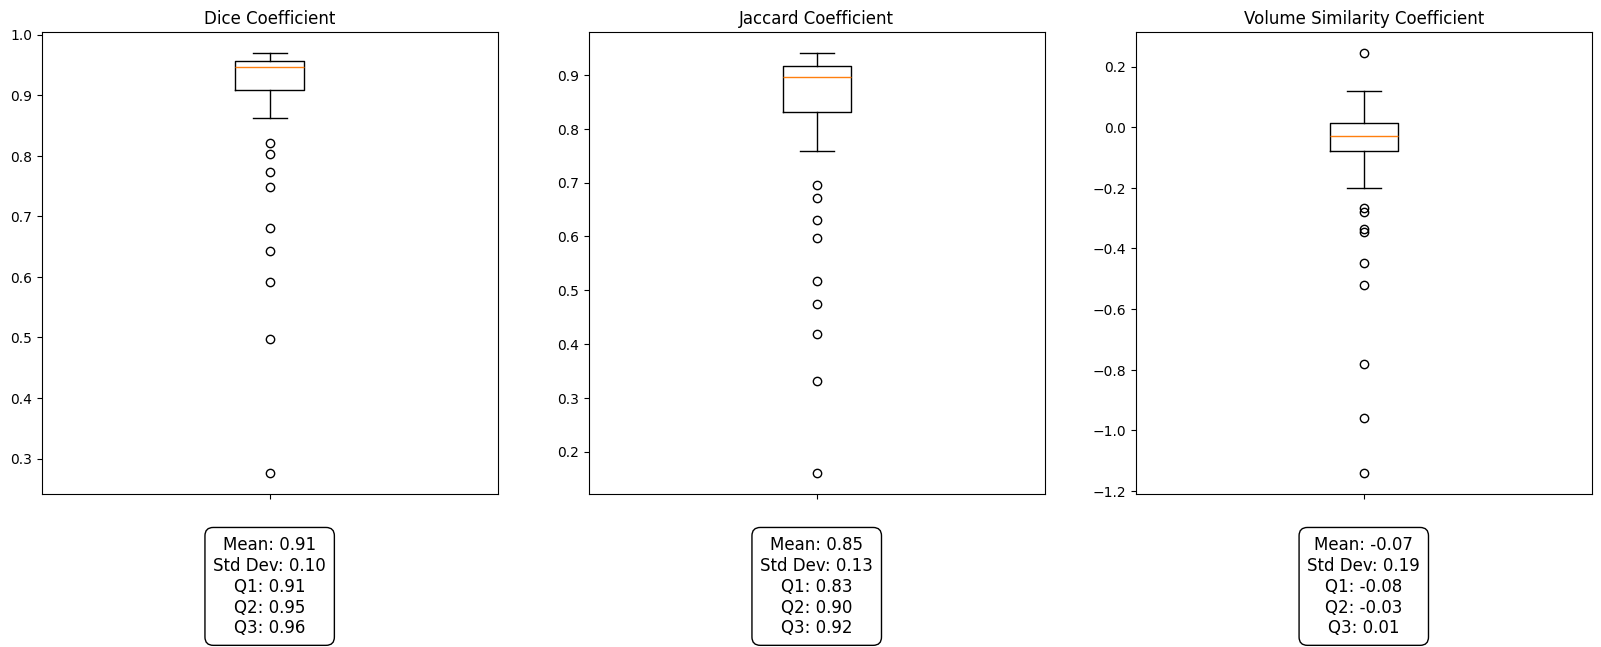

In [32]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

axes[0].boxplot(dice)
axes[0].title.set_text('Dice Coefficient')
axes[0].set_xticklabels([])

axes[1].boxplot(jaccard)
axes[1].title.set_text('Jaccard Coefficient')
axes[1].set_xticklabels([])

axes[2].boxplot(volume_similarity)
axes[2].title.set_text('Volume Similarity Coefficient')
axes[2].set_xticklabels([])

# Add a text box at the bottom
# fig.text(0.5, 0.05, 'This is a text box', ha='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

for ax, plotted_data in zip(axes, [dice, jaccard, volume_similarity]):
    mean, std, quartiles = calculate_stats(plotted_data)

    text = f'Mean: {mean:.2f}\nStd Dev: {std:.2f}\nQ1: {quartiles[0]:.2f}\nQ2: {quartiles[1]:.2f}\nQ3: {quartiles[2]:.2f}'

    ax.text(0.5, -0.2, text, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


plt.show()
